In [15]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from torch.utils.data import random_split, SubsetRandomSampler, DataLoader
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


In [16]:
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

1
0
NVIDIA GeForce GTX 1050 Ti


In [4]:
DATASET_NAME = "sherbrooke"

In [6]:
# Create normal trajectories dataset
normal_data_file = f"./data/augmented/{DATASET_NAME}/{DATASET_NAME}_gt_data.csv"
normal_data = np.genfromtxt(normal_data_file, delimiter=',')
# Remove the first column, which is the object_id
normal_data = normal_data[:, 1:]
print(f"Normal data shape: {normal_data.shape}")

# Create the generated abnormal dataset
abnormal_data_file = f"./data/augmented/{DATASET_NAME}/{DATASET_NAME}_gt_abnormal.csv"
abnormal_data = np.genfromtxt(abnormal_data_file, delimiter=',')
# Remove the first column, which is the object_id
abnormal_data = abnormal_data[:, 1:]
print(f"Abnormal data shape: {abnormal_data.shape}")

# Create the real abnormal datasets
real_abnormal_file = f"./data/augmented/{DATASET_NAME}/{DATASET_NAME}_gt_real_abnormal.csv"
real_abnormal_file_2 = f"./data/augmented/{DATASET_NAME}/{DATASET_NAME}_gt_real_abnormal_2.csv"
real_abnormal_data = np.genfromtxt(real_abnormal_file, delimiter=',')
real_abnormal_data_2 = np.genfromtxt(real_abnormal_file_2, delimiter=',')
# Remove the first column, which is the object_id
real_abnormal_data = real_abnormal_data[:, 1:]
real_abnormal_data_2 = real_abnormal_data_2[:, 1:]
print(f"Real abnormal data shape: {real_abnormal_data.shape}")

Normal data shape: (20606, 125)
Abnormal data shape: (186, 125)
Real abnormal data shape: (406, 125)


In [7]:
# Define the DAE
class DAE(nn.Module):
    def __init__(self,
                 input_size,
                 hidden_layers=(16,),
                 hidden_activation=nn.ReLU,
                 output_activation=nn.Sigmoid
                 ):
        super(DAE, self).__init__()
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.hidden_activation = hidden_activation
        self.output_activation = output_activation

        # Add the encoding layers
        self.encoded = self.create_layers(hidden_layers, input_size)

        # Add the decoding layers with the output activation function
        self.decoded = self.create_layers(hidden_layers[-2::-1], hidden_layers[-1])
        self.decoded.append(nn.Linear(hidden_layers[0], input_size))
        self.decoded.append(self.output_activation())

    def create_layers(self, design, input_size):
        layers = []
        for i, layer in enumerate(design):
            in_features = design[i-1] if i > 0 else input_size
            out_features = layer
            layers.append(nn.Linear(in_features, out_features))
            layers.append(self.hidden_activation())

        return nn.Sequential(*layers)

    def forward(self, input):
        encoded = self.encoded(input)
        # print(self.decoded)
        decoded = self.decoded(encoded)
        return decoded

In [114]:
BATCH_SIZE = 128
# Scale the data
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(normal_data)
train_data_scaled = torch.from_numpy(train_data_scaled).to(dtype=torch.float32)

test_data_scaled = scaler.fit_transform(abnormal_data)
test_data_scaled = torch.from_numpy(test_data_scaled).to(dtype=torch.float32)

test_data_real_scaled = scaler.fit_transform(real_abnormal_data)
test_data_real_scaled = torch.from_numpy(test_data_real_scaled).to(dtype=torch.float32)

test_data_real_scaled_2 = scaler.fit_transform(real_abnormal_data_2)
test_data_real_scaled_2 = torch.from_numpy(test_data_real_scaled_2).to(dtype=torch.float32)

# Create the KFold object for cross validation
folds = 10
splits = KFold(n_splits=folds, shuffle=True, random_state=42)

# Split into training and validation
# train_data_scaled, validation_data_scaled = train_test_split(train_data_scaled, test_size=0.2)
# train_data_scaled = torch.from_numpy(train_data_scaled)
# validation_data_scaled = torch.from_numpy(validation_data_scaled)

# train_dataloader = torch.utils.data.DataLoader(train_data_scaled, batch_size=BATCH_SIZE, shuffle=True)
# validation_dataloader = torch.utils.data.DataLoader(validation_data_scaled, batch_size=BATCH_SIZE, shuffle=True)

In [146]:
print("Training the deep autoencoder")
# Define hyperparameters
EPOCHS = 10
HIDDEN_LAYERS = (16,)
criterion = nn.MSELoss()
hidden_layers = (128,64,32,16,8)

# Define the model
model = DAE(input_size=train_data_scaled.shape[1], hidden_layers=hidden_layers).to(DEVICE)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)


history = {
    'train_score': [],
    'val_score': [],
    'train_loss': [],
    'val_loss': [],
    'threshold': [],
    'normal_ratio': []
}

for fold, (train_idx, val_idx) in enumerate(splits.split(train_data_scaled)):
    print(f"Fold {fold+1}")
    train_sampler = SubsetRandomSampler(train_idx)
    validation_sampler = SubsetRandomSampler(val_idx)
    train_dataloader = DataLoader(train_data_scaled, batch_size=BATCH_SIZE, sampler=train_sampler)
    validation_dataloader = DataLoader(train_data_scaled, batch_size=BATCH_SIZE, sampler=validation_sampler)

    # Train the model on the scaled data
    for epoch in range(EPOCHS):
        total_train_loss = 0
        total_validation_loss = 0
        print(f"Epoch {epoch}")
        for i, trajectories in enumerate(train_dataloader):
            trajectories = trajectories.to(DEVICE, dtype=torch.float32)
            # print(type(trajectories[0]))

            # Forward pass
            model.zero_grad()
            output = model(trajectories)
            loss = criterion(output, trajectories)
            total_train_loss += loss / len(train_dataloader)

            # Backward pass
            loss.backward()
            optimizer.step()

        history['train_loss'].append(total_train_loss.cpu())

        # Evaluate model at this epoch
        model.eval()
        model = model.cpu()
        with torch.no_grad():
            # Get the training score
            mse_per_sample_train = []
            for i, trajectories in enumerate(train_dataloader):
                output = model(trajectories)
                assert output.shape == trajectories.shape, "The predicted data shape is not right!"
                mse_per_sample_train.extend([mean_squared_error(trajectories[i], output[i]) for i in range(output.shape[0])])
            train_score = np.mean(mse_per_sample_train)
            print(f"Train score: {train_score}")
            history['train_score'].append(train_score)

            # Get validation score
            mse_per_sample_validation = []
            for i, trajectories in enumerate(validation_dataloader):
                output = model(trajectories)
                assert output.shape == trajectories.shape, "The predicted data shape is not right!"
                mse_per_sample_validation.extend([mean_squared_error(trajectories[i], output[i]) for i in range(output.shape[0])])

                # Also get loss for rating model
                loss = criterion(output, trajectories)
                total_validation_loss += loss / len(validation_dataloader)
            validation_score = np.mean(mse_per_sample_validation)
            print(f"Validation score: {validation_score}")
            history['val_score'].append(validation_score)
            history['val_loss'].append(total_validation_loss)

            # Calculate threshold
            threshold = train_score + validation_score + 3 * (np.std(mse_per_sample_train) + np.std(mse_per_sample_validation))
            print(f"Threshold value: {threshold}")
            history['threshold'].append(threshold)

            normal_train_ratio = sum([score < threshold for score in mse_per_sample_train])/float(len(mse_per_sample_train))
            print(f"Normal train ratio: {normal_train_ratio}")
            normal_valid_ratio = sum([score < threshold for score in mse_per_sample_validation])/float(len(mse_per_sample_validation))
            print(f"Normal validation ratio: {normal_valid_ratio}")
        model = model.to(DEVICE)
        model.train()

Training the deep autoencoder
Fold 1
Epoch 0
Train score: 0.010238777846097946
Validation score: 0.010351213626563549
Threshold value: 0.11949696391820908
Normal train ratio: 0.9951469398759774
Normal validation ratio: 0.9941775836972343
Epoch 1
Train score: 0.007665365003049374
Validation score: 0.007844705134630203
Threshold value: 0.07180174719542265
Normal train ratio: 1.0
Normal validation ratio: 0.9995147986414362
Epoch 2
Train score: 0.004427643958479166
Validation score: 0.004486580844968557
Threshold value: 0.04395624063909054
Normal train ratio: 1.0
Normal validation ratio: 1.0
Epoch 3
Train score: 0.0032562934793531895
Validation score: 0.003218825440853834
Threshold value: 0.031467534601688385
Normal train ratio: 1.0
Normal validation ratio: 1.0
Epoch 4
Train score: 0.002830724697560072
Validation score: 0.0028111792635172606
Threshold value: 0.02797398855909705
Normal train ratio: 1.0
Normal validation ratio: 1.0
Epoch 5
Train score: 0.00262845610268414
Validation score: 0

In [147]:
print(threshold)

0.007897915318608284


In [148]:
model = model.cpu()
model.eval()
with torch.no_grad():
    # Test score on abnormal data
    predicted_test_data = model(test_data_scaled)
    assert predicted_test_data.shape == test_data_scaled.shape, "The predicted data shape is not right!"
    mse_per_sample = [mean_squared_error(test_data_scaled[i], predicted_test_data[i]) for i in range(test_data_scaled.shape[0])]
    test_score = np.mean(mse_per_sample)
    print(f"Test score: {test_score}")

    abnormal_test_ratio = sum([score > threshold for score in mse_per_sample])/float(len(mse_per_sample))
    print(f"Abnormal ratio: {abnormal_test_ratio}")

Test score: 0.06164320185780525
Abnormal ratio: 1.0


In [124]:
# torch.save(model.state_dict(), "./models/10_epochs")
model = torch.load("models/10_epochs")

In [150]:
with torch.no_grad():
    # Test score on real abnormal data
    predicted_test_data = model(test_data_real_scaled)
    assert predicted_test_data.shape == test_data_real_scaled.shape, "The predicted data shape is not right!"
    mse_per_sample = [mean_squared_error(test_data_real_scaled[i], predicted_test_data[i]) for i in range(test_data_real_scaled.shape[0])]
    test_score = np.mean(mse_per_sample)
    print(f"Real test score: {test_score}")

    abnormal_test_ratio = sum([score > threshold for score in mse_per_sample])/float(len(mse_per_sample))
    print(f"Real abnormal ratio: {abnormal_test_ratio}")

Real test score: 0.034766051918268204
Real abnormal ratio: 0.896551724137931


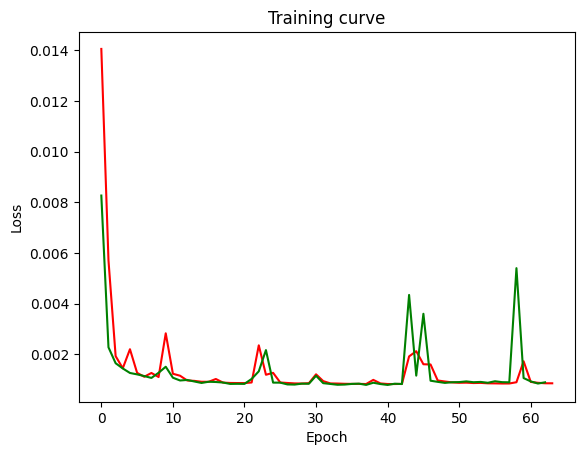

In [143]:
model = model.cpu()
model.eval()
with torch.no_grad():
    plt.title("Training curve")
    plt.plot(range(len(history['train_loss'])),history['train_loss'],'r')
    plt.plot(range(len(history['val_loss'])),history['val_loss'],'g')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

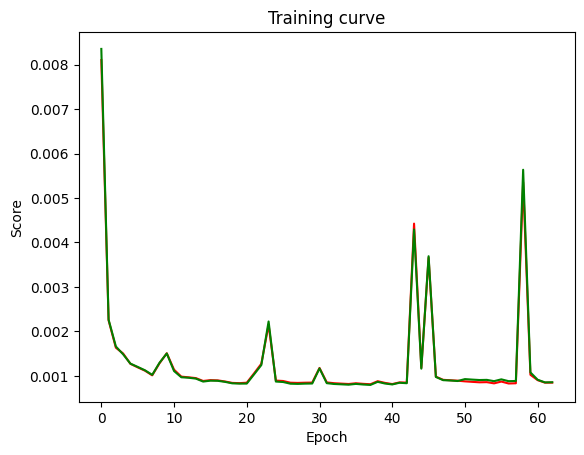

In [144]:
model = model.cpu()
model.eval()
with torch.no_grad():
    plt.title("Training curve")
    plt.plot(range(len(history['train_score'])),history['train_score'],'r')
    plt.plot(range(len(history['val_score'])),history['val_score'],'g')
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.show()

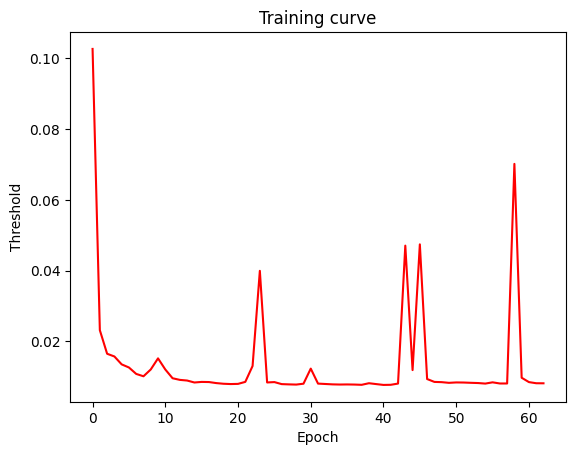

In [145]:
model = model.cpu()
model.eval()
with torch.no_grad():
    plt.title("Training curve")
    plt.plot(range(len(history['threshold'])),history['threshold'],'r')
    plt.xlabel("Epoch")
    plt.ylabel("Threshold")
    plt.show()

In [34]:
# Evaluate the model
model = model.cpu()
train_data_scaled = train_data_scaled.cpu()

model.eval()
with torch.no_grad():
    predicted_train_data = model(train_data_scaled)
    assert predicted_train_data.shape == train_data_scaled.shape, "The predicted data shape is not right!"
    mse_per_sample = [mean_squared_error(train_data_scaled[i], predicted_train_data[i]) for i in range(train_data_scaled.shape[0])]
    train_score = np.mean(mse_per_sample)
    print(f"Train score: {train_score}")

    predicted_test_data = model(test_data_scaled)
    assert predicted_test_data.shape == test_data_scaled.shape, "The predicted data shape is not right!"
    mse_per_sample = [mean_squared_error(train_data_scaled[i], predicted_train_data[i]) for i in range(train_data_scaled.shape[0])]
    train_score = np.mean(mse_per_sample)
    print(f"Train score: {train_score}")

Train score: 0.0028367689810693264
